In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import model_selection
from sklearn.preprocessing import scale
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [3]:
X = data.data
Y = np.stack((data.target, ~data.target+2), axis=-1)
n_inputs = X.shape[1]
print('numver of inputs:',n_inputs)

numver of inputs: 30


In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

Scale the data first, but I didn't figure out how to normalize data in tensorflow...

In [5]:
X_train = scale(X_train)
X_test = scale(X_test)

2 hidden layers of 5 and 10 units followed by a sigmoid activation function.

In [6]:
# hyperparametres
learning_rate = 0.005 # learning rate of optimizer
num_epochs = 1000
display_step = 10
trained_params_path = './ML_HW9'

# network parametres
n_hidden_1 = 5 # number of nodes in hidden layer 1
n_hidden_2 = 10 # number of nodes in hidden layer 2
n_inputs = X.shape[1] # number of inputs 
n_classes = Y.shape[1] # number of outputs

X = tf.placeholder(tf.float32, [None, n_inputs]) # X is our features placeholder. We'll feed data during training time.
y = tf.placeholder(tf.float32, [None, n_classes]) # y is our label placeholder. We'll feed data during training time.

weights = {
    'hidden1' : tf.Variable(tf.random_normal([n_inputs, n_hidden_1])), # weights of hidden layer 1
    'hidden2' : tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])), # weights of hidden layer 2
    'output' : tf.Variable(tf.random_normal([n_hidden_2, n_classes])) # weights of outpur layer
}

biases = {
    'hidden1' : tf.Variable(tf.random_normal([n_hidden_1])), # biases of hidden layer 1
    'hidden2' : tf.Variable(tf.random_normal([n_hidden_2])), # biases of hidden layer 2
    'output' : tf.Variable(tf.random_normal([n_classes])) # biases of output layer
}

In [7]:
layer_1_prediction = tf.add(tf.matmul(X, weights['hidden1']), biases['hidden1']) # layer 1 predicton: y = mx + b
layer_2_prediction = tf.add(tf.matmul(layer_1_prediction, weights['hidden2']), biases['hidden2']) # layer 2 prediction
prediction = tf.add(tf.matmul(layer_2_prediction, weights['output']), biases['output']) # final/ output layer prediction
output = tf.nn.softmax(prediction, name='output')

In [8]:
# let's calculate the cost using softmax cross entropy with logits
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction)) 
# we'll use Adapoptimizer for our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# calculate the correct prediction
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [9]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    saver = tf.train.Saver()
    history = []
    

    for step in range(num_epochs):
        sess.run(optimizer, feed_dict={X: X_train, y: y_train}) # we feed the real data into placeholder
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={X: X_train,
                                                                 y: y_train})
            test_loss, test_acc = sess.run([cost, accuracy], feed_dict={X: X_test,
                                                                 y: y_test})
            history += [[step] + [loss] + [acc] + [test_loss] + [test_acc]]
            # print debugging information
            print("Step " + str(step) + ", Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
    saver.save(sess, trained_params_path)
    print("Optimization Finished!")

    # Calculate accuracy for test
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_test,
                                      y: y_test}))

Step 0, Loss= 5.9121, Training Accuracy= 0.782
Step 1, Loss= 5.4756, Training Accuracy= 0.787
Step 10, Loss= 2.6967, Training Accuracy= 0.842
Step 20, Loss= 1.2182, Training Accuracy= 0.895
Step 30, Loss= 0.5882, Training Accuracy= 0.930
Step 40, Loss= 0.3638, Training Accuracy= 0.949
Step 50, Loss= 0.2617, Training Accuracy= 0.960
Step 60, Loss= 0.2200, Training Accuracy= 0.952
Step 70, Loss= 0.1953, Training Accuracy= 0.963
Step 80, Loss= 0.1747, Training Accuracy= 0.963
Step 90, Loss= 0.1574, Training Accuracy= 0.969
Step 100, Loss= 0.1430, Training Accuracy= 0.969
Step 110, Loss= 0.1305, Training Accuracy= 0.969
Step 120, Loss= 0.1198, Training Accuracy= 0.969
Step 130, Loss= 0.1108, Training Accuracy= 0.974
Step 140, Loss= 0.1032, Training Accuracy= 0.974
Step 150, Loss= 0.0969, Training Accuracy= 0.974
Step 160, Loss= 0.0916, Training Accuracy= 0.978
Step 170, Loss= 0.0873, Training Accuracy= 0.976
Step 180, Loss= 0.0836, Training Accuracy= 0.978
Step 190, Loss= 0.0805, Training 

In [10]:
history = pd.DataFrame(history, columns=['Step','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy'])

In [11]:
history.head()

,Step,Train_Loss,Train_Accuracy,Test_Loss,Test_Accuracy
0,0,5.912087,0.782418,5.197701,0.789474
1,1,5.475602,0.786813,4.797358,0.798246
2,10,2.696727,0.841758,2.463651,0.859649
3,20,1.218202,0.894506,1.504209,0.921053
4,30,0.588240,0.929670,0.868109,0.938596


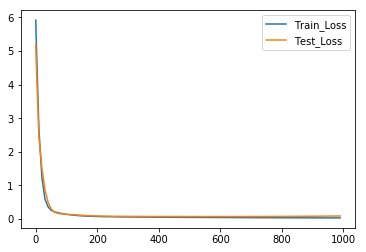

In [12]:
plt.figure()
plt.plot(history.Step, history.Train_Loss)
plt.plot(history.Step, history.Test_Loss)
plt.legend()
plt.show()

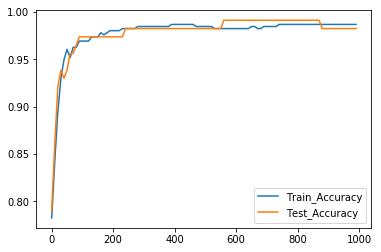

In [13]:
plt.figure()
plt.plot(history.Step, history.Train_Accuracy)
plt.plot(history.Step, history.Test_Accuracy)
plt.legend()
plt.show()

In [14]:
def predict(x_new, trained_params_path):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, trained_params_path)
        pr = output.eval(feed_dict={X: x_new})
        return pr

INFO:tensorflow:Restoring parameters from ./ML_HW9
(114, 2)


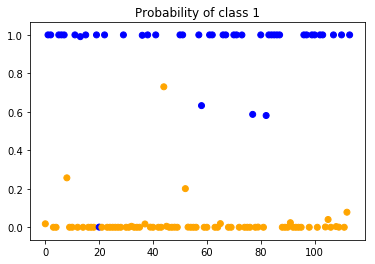

In [15]:
z = predict(X_test, trained_params_path)
print(z.shape)
# blue for class 0, orange for class 1
color = ['blue' if y[0] == 0 else 'orange' for y in y_test]
plt.figure()
plt.scatter(range(y_test.shape[0]), z[:,1], color=color)
plt.title('Probability of class 1')
plt.show()